## A/B testing of campaign effectiveness 

### Experimental design 
Since we want to know if the campaign perform better or worse( or the same).
The choice of test is two tailed test: 

**Assumption** 
* Null Hypothesis
    * This is the presumption that there is no significant difference between the two. 
    * written as: Hₒ: p = pₒ
* **Alternate Hypothesis** 
    * This is the presumption that there is a significant difference between the two. Here the Null hypothesis is rejected
    * Written as: Hₐ: p ≠ pₒ
    
NB-- p and pₒ is the conversion rate of the new and old design respectively. 

**Confidence level:**
 The confidence level is set at 95% \
 making alpha = 1- confidence level\
               = 1 - 0.95\
                α =0.05

## Variable selection 
A control group = The before the campaign
A treatment group = After the campaign

###  Test KPI 
Conversion rate -- This is used to denote the usage rate of PHV before and after the designated campaign.


## Sample size selection 
The shape of the data is 501369 rows , and 18 columns. 
The unique user count is 410352 users. The question is how many samples do we need. 

It is imporant to note that the sample size affect the precision of our estimates. The **larger the samples the more accurate/ precise our estimates are.**

* Method
Power Analysis 


In [1]:
#import the necessary libraries
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
import pandas as pd
import numpy as np
import math
import csv 
from scipy.stats import norm

In [2]:
#read the data uisng pandas 
df = pd.read_csv('case_study_data.csv')

/Users/emeka/opt/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3444: DtypeWarning: Columns (3) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [3]:
df[['date_deposit','date_redemption']]=df[['date_deposit','date_redemption']].apply(lambda x: pd.to_datetime(x,format='%Y-%m-%d'))

In [4]:
df.id_p.value_counts()

NzA1ODIwMQ==    10
MzQwMDU4ODk=    10
NDg2NDM4Nzc=    10
NTc0Nzc0NDc=     9
MTgyMjMzOTU=     9
                ..
MjA0NTA3NzA=     1
MjA0NTA1OTE=     1
MjA0NTA1Mjc=     1
MjA0NDkyOTM=     1
MzIyODg4MjQ=     1
Name: id_p, Length: 410352, dtype: int64

In [5]:
# Explore the data set by Printing the details of the dataset
maxdate = df['date_deposit'].dt.date.max()
mindate = df['date_deposit'].dt.date.min()
unique_cust = df['id_p'].nunique()
tot_tours = df['lifetime_tours'].sum()
tot_rev = df['campaign_revenue'].sum()


print(f"The time range of transactions is: {mindate} to {maxdate}")
print(f"Total number of unique customers: {unique_cust}")
print(f"Total quantity Sold: {tot_tours}")
print(f"Total sales for the period: ${tot_rev.round(2)})")


The time range of transactions is: 2019-11-28 to 2019-12-17
Total number of unique customers: 410352
Total quantity Sold: 19540138.0
Total sales for the period: $222755.39)


In [6]:
df.shape

(501369, 18)

In [7]:
df.describe()

,lifetime_tours,lifetime_phv_tours,pre_campaign_phv_tours,campaign_phv_tours,pas_lc_status,pas_c_status,deposits,deposits_PAS,redeemed_PAS,campaign_tours,campaign_revenue,campaign_gmv,campaign_discount_value
count,501137.000000,501137.000000,501137.000000,501137.000000,501234.000000,501234.000000,501369.000000,501369.0,501369.000000,501369.000000,94720.000000,94720.000000,94720.000000
mean,38.991609,6.510952,5.703885,0.807067,3.207097,3.084733,5.714189,1.0,0.188923,0.230447,2.351725,10.093243,2.178709
std,98.715459,15.902053,14.602252,1.953439,0.849154,1.148651,2.311474,0.0,0.391448,0.526843,1.415499,6.068438,1.638637
min,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.0,0.000000,0.000000,0.562358,2.249433,0.224943
25%,2.000000,0.000000,0.000000,0.000000,2.000000,2.000000,6.000000,1.0,0.000000,0.000000,1.359501,5.826032,0.956009
50%,8.000000,0.000000,0.000000,0.000000,3.000000,4.000000,7.000000,1.0,0.000000,0.000000,2.010431,8.604081,1.777052
75%,32.000000,6.000000,4.000000,1.000000,4.000000,4.000000,7.000000,1.0,0.000000,0.000000,2.956950,12.709297,2.811791
max,4719.000000,378.000000,341.000000,68.000000,4.000000,4.000000,7.000000,1.0,1.000000,7.000000,29.289024,128.909383,26.678276


In [8]:
data= df[['id_p','date_deposit','date_redemption','lifetime_tours','lifetime_phv_tours','pre_campaign_phv_tours','campaign_phv_tours','deposits_PAS']]

In [9]:
data.deposits_PAS.value_counts()

1    501369
Name: deposits_PAS, dtype: int64

## Aggregate or clean 
From the dataset it is observed that some user_id is captured more than once, we can group by the user id, then continue with analysis. Droping the users will not be wise because of the quantiy of records it involves.


In [10]:
#group by customer 
customer_= data.groupby(by='id_p', as_index=False).agg({"pre_campaign_phv_tours": 'sum','campaign_phv_tours':'sum','deposits_PAS':'sum'})
customer_

,id_p,pre_campaign_phv_tours,campaign_phv_tours,deposits_PAS
0,MTA0MDAxNDA=,0.0,0.0,1
1,MTA0MDE2MDY=,1.0,0.0,1
2,MTA0MDE5ODQ=,2.0,0.0,1
3,MTA0MDEwODA=,24.0,2.0,2
4,MTA0MDExNTc=,1.0,0.0,1
...,...,...,...,...
410347,OTkzODc1,0.0,2.0,2
410348,OTkzODcwMA==,0.0,0.0,1
410349,OTkzODk2OQ==,0.0,0.0,1
410350,OTkzOTE3OQ==,0.0,0.0,1


In [11]:
customer_.deposits_PAS.value_counts()

1     363961
2      22752
3      11467
4       6217
5       3645
6       1779
7        520
8          6
10         3
9          2
Name: deposits_PAS, dtype: int64

In [12]:
#declare the features for conversions
customer_['Pre_camp']= (customer_['pre_campaign_phv_tours']>0)*1
customer_['During_camp']=(customer_['campaign_phv_tours']>0)*1
customer_['Neu_Lift'] = ((customer_['Pre_camp']==0)& (customer_['During_camp']==1))*1
customer_['Old_Lift'] = ((customer_['Pre_camp']==1)& (customer_['During_camp']==1))*1
#customer_['Neu_ad'] = (customer_['deposits_PAS']>0)*1  # add for new customers
customer_['Neu_ad'] = customer_['deposits_PAS'].apply(lambda x: 1 if x > 0 else 0)

# Explore the data set by Printing the details of the dataset
ttour_pre = data['pre_campaign_phv_tours'].sum()
ttour_post = data['campaign_phv_tours'].sum()
ttour_poten= customer_['deposits_PAS'].sum()

print(f"The total pre campaign tours: {ttour_pre}")
print(f"Total  total campaign tours: {ttour_post}")
print(f"Total  total campaign deposits: {ttour_poten}")

The total pre campaign tours: 2858428.0
Total  total campaign tours: 404451.0
Total  total campaign deposits: 501369


In [13]:
# Quick overview of conversions 
precamp_conv = customer_['Pre_camp'].sum()
camp_conv = customer_['During_camp'].sum()
new_PHV_entry = customer_['Neu_Lift'].sum()
retained_PHV_entry = customer_['Old_Lift'].sum()

print(f"The total pre campaign conversion is: {precamp_conv}")
print(f"The total campaign conversion is: {camp_conv}")
print(f"New entry to the PHV market: {new_PHV_entry}")
print(f"Retained PHV users: {retained_PHV_entry}")


The total pre campaign conversion is: 148838
The total campaign conversion is: 44185
New entry to the PHV market: 4598
Retained PHV users: 39587


In [14]:
##Split the cotrol and test experieent data

In [15]:
control = customer_[['id_p','pre_campaign_phv_tours']]
test = customer_[['id_p','campaign_phv_tours']]

In [16]:
#declare the features for conversions
control.loc[:,'conv']= (control['pre_campaign_phv_tours']>0)*1
test.loc[:,'conv']=(test['campaign_phv_tours']>0)*1
control.loc[:,'group']= 'control'
test.loc[:,'group'] = 'test'
#rename columns
control.rename(columns={"pre_campaign_phv_tours": "tours"},inplace=True)
test.rename(columns={"campaign_phv_tours": "tours"}, inplace=True)


/Users/emeka/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
/Users/emeka/opt/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:5039: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


In [17]:
exp_data = pd.concat([control, test], axis = 0)
exp_data 

,id_p,tours,conv,group
0,MTA0MDAxNDA=,0.0,0,control
1,MTA0MDE2MDY=,1.0,1,control
2,MTA0MDE5ODQ=,2.0,1,control
3,MTA0MDEwODA=,24.0,1,control
4,MTA0MDExNTc=,1.0,1,control
...,...,...,...,...
410347,OTkzODc1,2.0,1,test
410348,OTkzODcwMA==,0.0,0,test
410349,OTkzODk2OQ==,0.0,0,test
410350,OTkzOTE3OQ==,0.0,0,test


## Get sample size

In [18]:

def get_power(n, p1, p2, cl):
    '''
    This function gets the scores the combination of samplesize, shift and confidence level'''
   
    alpha = 1 - cl
    qu = stats.norm.ppf(1 - alpha/2)
    diff = abs(p2-p1)
    bp = (p1+p2) / 2
    
    v1 = p1 * (1-p1)
    v2 = p2 * (1-p2)
    bv = bp * (1-bp)
    power_part_one = stats.norm.cdf((n**0.5 * diff - qu * (2 * bv)**0.5) / (v1+v2) ** 0.5)
    power_part_two = 1 - stats.norm.cdf((n**0.5 * diff + qu * (2 * bv)**0.5) / (v1+v2) ** 0.5)
    power = power_part_one - power_part_two
    return (power)

p1= customer_['Pre_camp'].mean()
p2 = customer_['During_camp'].mean()
p1,p2
#Test the values of the sample size and confidence interval to know it effect on the power function
get_power(10, p1, p2, 0.95)
get_power(200, p1, p2, 0.95)  
get_power(10, p1, p2, 0.8) 

0.5234055632805942

**Findings **

* *The sample size affect the power value possitively*
* *The confidence interval possitively affects the power value.

## Sample size

In [19]:
def get_sample_size(power, p1, p2, cl, max_n=1000000):
    '''
    This functions calculates the sample size of experiment.
    '''
    n = 1 
    while n <= max_n:
        tmp_power = get_power(n, p1, p2, cl)

        if tmp_power >= power: 
            return n 
        else: 
            n = n + 100

In [20]:
c_r_con =  customer_['Pre_camp'].sum()/customer_['Pre_camp'].count()
c_r_test = customer_['During_camp'].sum()/customer_['During_camp'].count()

In [21]:
#test 1
conversion_rate = customer_['Pre_camp'].sum()/customer_['Pre_camp'].count()
power = 0.8
cl = 0.95
percent_lift = 0.03
conversion_rate_p2 = conversion_rate * (1 + percent_lift)
get_sample_size(power, conversion_rate, conversion_rate_p2, cl)

30901

In [22]:
#test2
conversion_rate = customer_['Pre_camp'].sum()/customer_['Pre_camp'].count()
power = 0.9
cl = 0.95
percent_lift = 0.05
conversion_rate_p2 = conversion_rate * (1 + percent_lift)
get_sample_size(power, conversion_rate, conversion_rate_p2, cl)

15001

In [23]:
#test 3
conversion_rate = customer_['Pre_camp'].sum()/customer_['Pre_camp'].count()
power =0.80
cl = 0.95
percent_lift = 0.01
conversion_rate_p2 = conversion_rate * (1 + percent_lift)
get_sample_size(power, conversion_rate, conversion_rate_p2, cl)

276501

From the three test above, 
* **using power = 0.80, cl= 0.95 and lift 0.03**
* **using power = 0.90, cl= 0.95 and lift 0.05**
* **using power = 0.95, cl= 0.95 and lift 0.02**

From the calculation above, the the best power value means a total of 276501 records will be selected at random from the control and test set.

In [24]:
#Randomly select 276501 samples values 
required_n= 276501 
control_sample = exp_data[exp_data['group'] == 'control'].sample(n=required_n, random_state=22)
treatment_sample = exp_data[exp_data['group'] == 'test'].sample(n= required_n, random_state=22)
ab_test = pd.concat([control_sample, treatment_sample], axis=0)
ab_test.reset_index(drop=True, inplace=True)

In [25]:
#count to verify 
ab_test['group'].value_counts()

control    276501
test       276501
Name: group, dtype: int64

In [61]:
test_summ = ab_test.groupby(by='group', as_index=False).agg({'id_p': 'count','conv':'sum'})
conversion_rates = ab_test.groupby('group')['conv']

std_p = lambda x: np.std(x, ddof=0)              # Std. deviation of the proportion
se_p = lambda x: stats.sem(x, ddof=0)            # Std. error of the proportion (std / sqrt(n))
me_p = lambda x: np.mean(x, ddof=0)

conversion_rates = conversion_rates.agg([np.mean, std_p, se_p])
conversion_rates.columns = ['conversion_rate', 'std_deviation', 'std_error']

conversion_rates.style.format('{:.3f}')

,conversion_rate,std_deviation,std_error
group,,,
control,0.362,0.480,0.001
test,0.107,0.309,0.001


In [47]:
x= conversion_rates.index

Index(['control', 'test'], dtype='object', name='group')

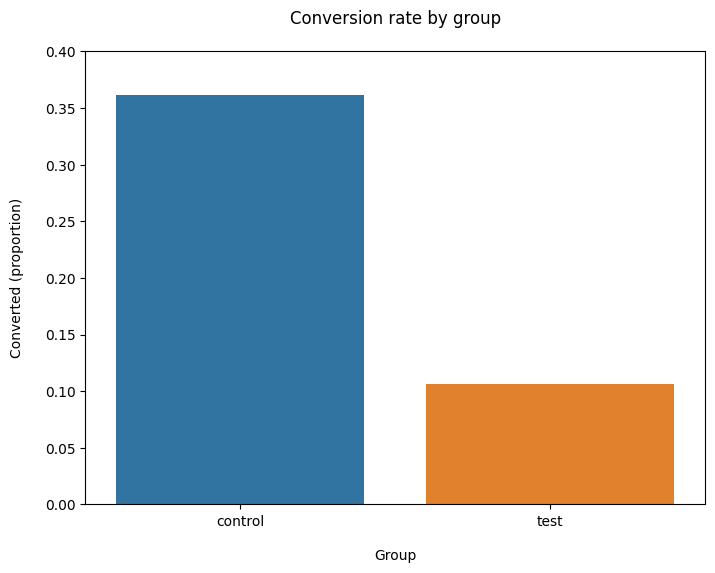

In [27]:
plt.figure(figsize=(8,6),dpi=100)
sns.barplot(x=ab_test['group'], y=ab_test['conv'], ci=False)
plt.ylim(0, 0.4)
plt.title('Conversion rate by group', pad=20)
plt.xlabel('Group', labelpad=15)
plt.ylabel('Converted (proportion)', labelpad=15);

## Is it Stastically significant?

Statistical Significance: we ask are the conversion rates different enough? If yes then we reject the null hypothesis.\
Remember form the top we need 95% confidence, any less believe that this change happens due to randomess. Then we reject right away. 

## Get p-values

In [28]:
# group conversion rates and group sizes
def get_pvalue(c_r_con, c_r_test,contl_size, test_size,):
    lift = - abs(c_r_test - c_r_con)
    scale_one = c_r_con * (1 - c_r_con) * (1 / contl_size) 
    scale_two = c_r_test * (1 - c_r_test) * (1 / test_size) 
    scale_val = (scale_one + scale_two)**0.5
    p_value = 2 * stats.norm.cdf(lift, loc = 0, scale = scale_val )
    return p_value.round(5)

#we have some already estimated quantities 
contl_size = 410352
test_size  = 410352
c_r_con =  0.362 #conversion rate control
c_r_test = 0.107  #conversion rate test
p_value = get_pvalue(c_r_con, c_r_test, contl_size,test_size) 
print(p_value)
# Check for statistical significance
if p_value >= 0.05:
    print("Not Significant")
else:
    print("Significant Result")

0.0
Significant Result


Very strong eveidence against the null Hypothesis.
The control and test samples exhibits a significant difference.

## Confidence interval

In [29]:
def get_ci(test_conv, con_conv,test_size, con_size, ci):
    sd = ((test_conv * (1 - test_conv)) / test_size + (con_conv * (1 - con_conv)) / con_size)**0.5
    lift = test_conv - con_conv
    val = stats.norm.isf((1 - ci) / 2) 
    lwr_bnd = lift - val * sd
    upr_bnd = lift + val * sd 
    return((lwr_bnd, upr_bnd))

In [30]:
#confidence interval 
lwr_bnd, upr_bnd=get_ci(c_r_test, c_r_con,test_size, contl_size, 0.95)
lwr_bnd, upr_bnd

(-0.25674830042071056, -0.25325169957928945)

In [31]:
c_r_test-c_r_con

-0.255

A very narrow interval like seen from above, \
indicates a strong confidence of about 95% on range (- .2567 and -0.2532) the negative sign shows that this is a directional analysis. it needs to be analysed further using on tailed test.

In [32]:
#Mean of experiement data for control and Test
mean_con = control_sample['conv'].mean()
mean_test = treatment_sample['conv'].var()

In [33]:
v_c =control_sample['conv'].var()
v_t=treatment_sample['conv'].var()

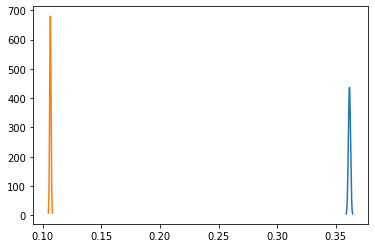

In [35]:
# Use our mean values to calculate the variance
mean_con = control_sample['conv'].mean()
mean_test = treatment_sample['conv'].mean()
var_con = (mean_con * (1 - mean_con)) / required_n 
var_test = (mean_test * (1 - mean_test)) / required_n
#var_con=v_c 
#var_test=v_t
# Generate a range of values across the
# distribution from +/- 3 sd around the mean 
con_line = np.linspace(-3 * var_con**0.5 +mean_con, 3 * var_con**0.5 + mean_con, 1000) 
test_line = np.linspace(-3 * var_test**0.5 +mean_test, 3 * var_test**0.5 + mean_test, 1000)
# Plot the probabilities across the distributioin of conversion rates 
plt.plot(con_line,norm.pdf(con_line, mean_con,var_con**0.5) )
plt.plot(test_line,norm.pdf(test_line, mean_test, var_test**0.5))

plt.show()

In [36]:
lift = mean_test - mean_con
var = var_test + var_con

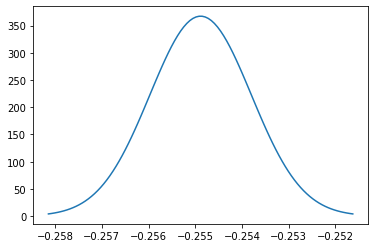

In [37]:
# Plot our difference in conversion rates
# as a distribution
diff_line = np.linspace(-3 * var**0.5 + lift,3 * var**0.5 + lift, 100 )
plt.plot(diff_line,norm.pdf( diff_line, lift, var**0.5)) 
plt.show()

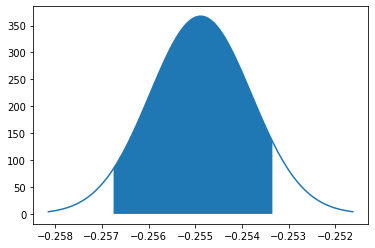

In [38]:
 # Find values over our confidence interval
section = np.arange(lwr_bnd, upr_bnd , 1/10000)
# Fill in between those boundaries
plt.fill_between( section,norm.pdf(section,lift, var**0.5) )
# Plot the difference with the confidence int.
plt.plot(diff_line,norm.pdf(diff_line, lift, var**0.5) )
plt.show()

In [39]:
test_summ

,group,id_p,conv
0,control,276501,99959
1,test,276501,29483


In [40]:
num_con = required_n  #Number of control values
num_tre = required_n #Number of treatment values
cntrl, trment = 99959, 29483  #converted customers for treatment and control
rate_cont, rate_treatment = cntrl / num_con, trment / num_tre

In [41]:
a_dist = np.zeros(num_con)
a_dist[:cntrl] = 1
b_dist = np.zeros(num_tre)
b_dist[:trment] = 1

# Test 2 : Mann-Whitney U test

in this test the null hypothesis is tested. The value "less" indicated, is that the alternative is saying  than the 

In [42]:
from scipy.stats import mannwhitneyu
stat, p_value = mannwhitneyu(a_dist, b_dist, alternative="greater")
print(f"Mann-Whitney U test for null hypothesis A <= B is {p_value:0.3f}")

Mann-Whitney U test for null hypothesis A <= B is 0.000


**Findings** 
* The null hypothesis here is that A(control) is less than or equal b(treatment), the alternate hypothesis is that A greater. 
* As seen form the caluclation the **P-Value** is less than 0.05. it solidifies our take that A(control) is better. 

# Test 3: ## One tail Test 

#### Is B better than A?

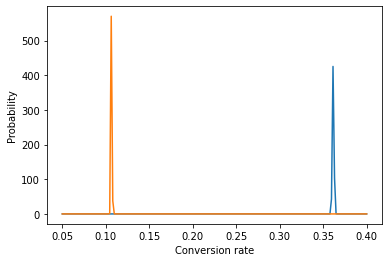

In [43]:

from scipy.stats import norm
rate_cont
rate_treatment 
num_a = required_n
num_b = required_n
# Where does this come from? See the link above.
std_a = np.sqrt(rate_cont * (1 - rate_cont) / num_a)
std_b = np.sqrt(rate_treatment  * (1 - rate_treatment ) / num_b)

click_rate = np.linspace(0.05, 0.4, 200)
prob_a = norm(rate_cont, std_a).pdf(click_rate)
prob_b = norm(rate_treatment, std_b).pdf(click_rate)

# Make the bar plots.
plt.plot(click_rate, prob_a, label="A")
plt.plot(click_rate, prob_b, label="B")
plt.xlabel("Conversion rate"); plt.ylabel("Probability");

z-score is 234.709, with p-value 0.000


Text(1, 5, 'Area=0.000')

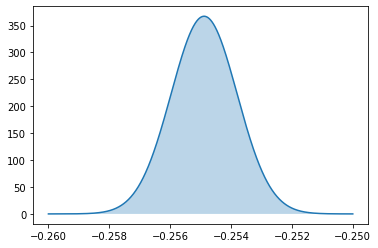

In [44]:
# The z-score is really all we need if we want a number
z_score = (rate_cont-rate_treatment ) / np.sqrt(std_a**2 + std_b**2)
print(f"z-score is {z_score:0.3f}, with p-value {norm().sf(z_score):0.3f}")
lift= rate_treatment - rate_cont
# But I want a plot as well
p = norm(rate_treatment - rate_cont, np.sqrt(std_a**2 + std_b**2))
x = np.linspace(-0.26, -0.25, 1000)
y = p.pdf(x)
area_under_curve = p.sf(0)
plt.plot(x, y, label="PDF")
plt.fill_between(x, y, label="Prob(a>b)", alpha=0.3)
plt.annotate(f"Area={area_under_curve:0.3f}", (1, 5))

In [45]:
def get_confidence_ab_test(rate_a ,rate_b):
    std_a = np.sqrt(rate_a * (1 - rate_a) / num_a)
    std_b = np.sqrt(rate_b * (1 - rate_b) / num_b)
    z_score = (rate_a-rate_b ) / np.sqrt(std_a**2 + std_b**2)
    return norm.cdf(z_score)

print(get_confidence_ab_test(rate_cont,rate_treatment))

# Draw 10000 samples of possible rates for a and b
n = 100000
rates_a = norm(rate_cont, std_a).rvs(n)
rates_b = norm(rate_treatment, std_b).rvs(n)
b_better = (rates_a>rates_b).mean()
print(f"Control is better than treatment {b_better:0.1%} of the time")

1.0
Control is better than treatment 100.0% of the time


** End Note**
* It can be reprased  B > A only ~0% of the time.
* which is statistically significant such that we can reject our hypothesis (that A <= B).
* It is important to note that the time range for Control to achieve it conversion rate isn't stated..
* Here we assume it is also 2 weeks data. 